By directly comparing the UVF_weights of [FHD](https://github.com/EoRImaging/FHD)+[$\epsilon$ppsilon](https://github.com/EoRImaging/eppsilon) output and the UV coverage (uvf_cube) created by this package, we can establish the extent to which the py21cmwedge UV_coverage estimation recovers the shape of uv_weights predicted by the FHD+$\epsilon$ppsilon software.

The Beam_Gridding notebook demonstrated that with the same uv resolution, this package and FHD agree about how baselines are gridded and combined in the (u,v) plane.
Here we compare how $\epsilon$ppsilon interprets the FHD output and how that compares to this package.

In [ ]:
%matplotlib notebook
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
import matplotlib.ticker as ticker
from astropy.io import fits
from matplotlib.colors import SymLogNorm, LogNorm
from py21cmwedge import UVGridder, cosmo, dft
from scipy.io import readsav
import glob

# filename='/home/mkolopanis/src/PRISim/prisim/data/beams/HERA_HFSS_X4Y2H_4900.hmap'
filename = "/home/mkolopanis/fhd_wedge_power/FHD_beam_x.fits"

In [ ]:
def rotate_map(hmap, rot=None, deg=False, **kwargs):
    """
    Take hmap (a healpix map array) and return another healpix map array
    which is ordered such that it has been rotated in (theta, phi) by the
    amounts given.
    """
    nside = hp.npix2nside(len(hmap))

    # Get theta, phi for non-rotated map
    t, p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))  # theta, phi

    # Define a rotator
    r = hp.Rotator(deg=deg, rot=rot, **kwargs)

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t, p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hmap, trot, prot)

    return rot_map

In [ ]:
# Load the HFSS beam simulation of a HERA dish
beam = fits.getdata(filename, "BEAM_X")
freqs = fits.getdata(filename, "FREQS_X")
ind = np.argmin(abs(freqs - 150e6))
beam_150 = beam[:, ind]
freq = 150e6
redshift = 1420e6 / freq - 1

In [ ]:
# Load up the HERA_37 FHD + Eppsilon output weights cube
weight_list = glob.glob(
    "/home/mkolopanis/fhd_wedge_power/fhd_hera_37_6sep/ps/*weights_uvf*.idlsave"
)
weight_filename = weight_list.pop()
weight_file = readsav(weight_filename)

kx = weight_file.kx_rad_vals / cosmo.comoving_distance(redshift)
ky = weight_file.ky_rad_vals / cosmo.comoving_distance(redshift)
weights_cube = weight_file.weights_cube

fhd_us = cosmo.kperp2u(kx, 8.47)
fhd_ind = weights_cube.shape[0] / 2

In [5]:
# Set the uv resolution of the UVGridder to match eppsilon weights cube
delta_u = np.diff(fhd_us)[0]

In [ ]:
new_beam = rotate_map(beam_150, [np.pi / 2, 0, 0], deg=False)
new_beam = rotate_map(new_beam, [0, np.pi / (12 * 3600) * 330 * 2, 0], deg=False)
uv_beam = dft.hpx_to_uv(new_beam * new_beam.conj(), delta_u)
uv_beam /= uv_beam.sum()
inds = np.argwhere(np.abs(uv_beam) <= np.abs(uv_beam).max() / 10)
uv_beam[inds[:, 0], inds[:, 1]] = 0

In [ ]:
# Set up the UVGridder object for HERA 37
gridder = UVGridder()
gridder.set_uv_delta(delta_u)  # Size of pixel in the UV plane (in wavelengths)
# gridder.set_beam(beam_150)
gridder.set_uv_beam(uv_beam)
gridder.read_antpos(
    "/home/mkolopanis/hera_sims/hera_layouts/antenna_positions_37.dat", skiprows=1
)
gridder.set_freqs(freq)
gridder.calc_all()
us_grid = np.arange(gridder.uv_size).astype(np.float64) - (gridder.uv_size - 1) / 2
us_grid *= gridder.uv_delta
ks_grid = cosmo.u2kperp(us_grid, redshift)

But we know that PRISim only outputs 1 copy of each redundant baseline type,

so we should recalculate the uvf_cube from py21cmwedge in a totally uniform weighting scenario:

In [8]:
new_dict = {}
for key in gridder.uvbins:
    new_dict[key] = [gridder.uvbins[key][0]]

In [9]:
import copy

new_gridder = copy.copy(gridder)
new_gridder.uvbins = new_dict
new_gridder.grid_uvw()

In [10]:
fhd_us_ind = np.logical_and(fhd_us > 10, fhd_us < 40)
ks_ind = np.logical_and(us_grid > 10, us_grid < 40)

<IPython.core.display.Javascript object>


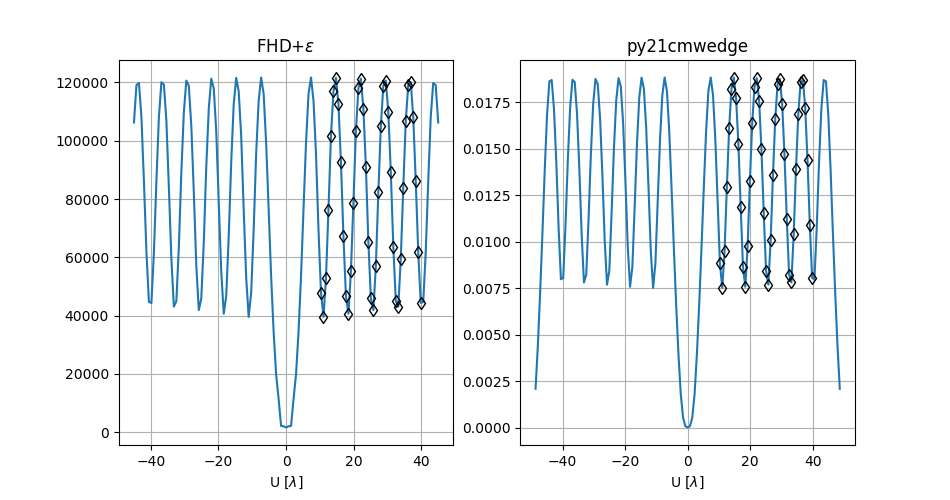

In [ ]:
fig, axes = subplots(ncols=2, figsize=(9.5, 5))
# for i in range(axes.size):
#     axes[i].xaxis.set_major_locator(ticker.MultipleLocator(.1))

axes[0].plot(fhd_us, np.abs(weights_cube[fhd_ind, 0, :]))
axes[0].plot(
    fhd_us[fhd_us_ind],
    np.abs(weights_cube[fhd_ind, 0, :])[fhd_us_ind],
    "kd",
    mfc="none",
)

axes[0].grid()
# axes[0].set_xlim([-.5,.5])
axes[0].set_title("FHD+$\epsilon$")
axes[0].set_xlabel("U [$\lambda$]")

axes[1].plot(us_grid, np.abs(new_gridder.uvf_cube[0, (new_gridder.uv_size - 1) / 2]))
axes[1].plot(
    us_grid[ks_ind],
    np.abs(new_gridder.uvf_cube[0, (new_gridder.uv_size - 1) / 2])[ks_ind],
    "kd",
    mfc="none",
)

axes[1].grid()
# axes[1].yaxis.set_major_locator(ticker.MultipleLocator(.01))
# axes[1].set_xlim({-.5,.5})
axes[1].set_title("py21cmwedge")
axes[1].set_xlabel("U [$\lambda$]")

To compare these two uvf_cubes let us compare the standard devation /  mean evaulated over a region of uv space:

For an example we will consider all the k_values in the range $10 < |u| < 40$     $\lambda$

In [ ]:
fhd_mean = np.mean(np.abs(weights_cube[fhd_ind, 0])[fhd_us_ind])
fhd_std = np.std(np.abs(weights_cube[fhd_ind, 0])[fhd_us_ind])
wedge_mean = np.mean(
    np.abs(new_gridder.uvf_cube[0, (new_gridder.uv_size - 1) / 2])[ks_ind]
)
wedge_std = np.std(
    np.abs(new_gridder.uvf_cube[0, (new_gridder.uv_size - 1) / 2])[ks_ind]
)


print("Simulation\tMean\t\tStd\t\tStd/Mean")
print(
    "FHD        \t{0:.3e}\t{1:.3e}\t{2:.3e}".format(
        fhd_mean, fhd_std, fhd_std / fhd_mean
    )
)
print(
    "Py21cmwedge\t{0:.3e}\t{1:.3e}\t{2:.3e}".format(
        wedge_mean, wedge_std, wedge_std / wedge_mean
    )
)

Simulation	Mean		Std		Std/Mean
FHD        	8.226e+04	2.875e+04	3.495e-01
Py21cmwedge	1.354e-02	3.984e-03	2.942e-01


The PRISim simulation also contains rotation synthesis over 660s made in 60s time intervals

We can also produce these effects using py21cmwedge's simulation_observation function

In [ ]:
new_uvw_array = []

for key in new_dict:
    _u, _v = map(float, key.split(","))
    new_uvw_array.append([_u, _v, 0])

new_uvw_array = np.unique(new_uvw_array, axis=0)

In [ ]:
synth_gridder = copy.copy(gridder)
synth_gridder.set_uvw_array(new_uvw_array)
synth_gridder.set_latitude(-30.7224 * np.pi / 180)
synth_gridder.set_t_int(11)
synth_gridder.set_n_obs(60)
synth_gridder.calc_all()

<IPython.core.display.Javascript object>


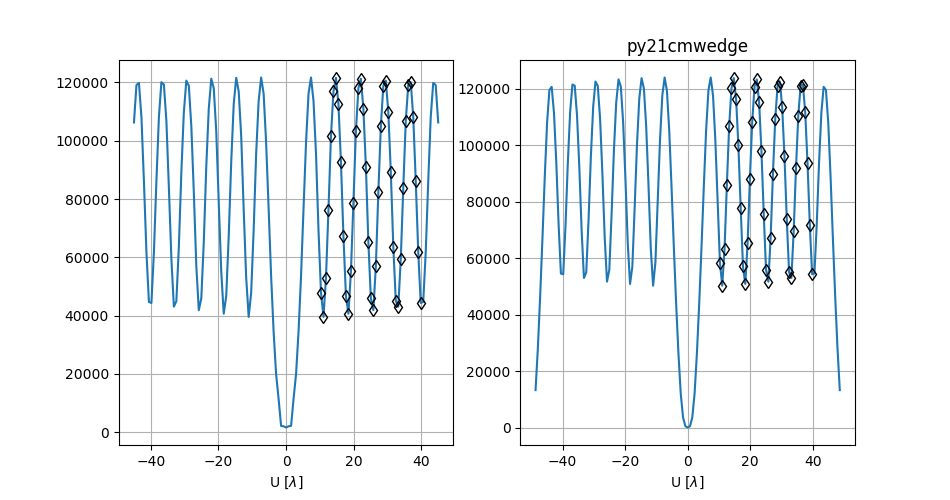

In [ ]:
newfig, axes = subplots(ncols=2, figsize=(9.5, 5))
# for i in range(axes.size):
#     axes[i].xaxis.set_major_locator(ticker.MultipleLocator(.1))
norm = np.abs(weights_cube[fhd_ind]).max() / np.abs(synth_gridder.uvf_cube[0]).max()

axes[0].plot(fhd_us, np.abs(weights_cube[fhd_ind, 0, :]))
axes[0].plot(
    fhd_us[fhd_us_ind],
    np.abs(weights_cube[fhd_ind, 0, :])[fhd_us_ind],
    "kd",
    mfc="none",
)

axes[0].grid()
# axes[0].set_xlim([-.5,.5])
# axes[0].set_title("FHD+$\epsilon$")
axes[0].set_xlabel("U [$\lambda$]")

axes[1].plot(
    us_grid, np.abs(synth_gridder.uvf_cube[0, (synth_gridder.uv_size - 1) / 2]) * norm
)
axes[1].plot(
    us_grid[ks_ind],
    np.abs(synth_gridder.uvf_cube[0, (synth_gridder.uv_size - 1) / 2])[ks_ind] * norm,
    "kd",
    mfc="none",
)

axes[1].grid()
# axes[1].yaxis.set_major_locator(ticker.MultipleLocator(.01))
# axes[1].set_xlim({-.5,.5})
axes[1].set_title("py21cmwedge")
axes[1].set_xlabel("U [$\lambda$]")

In [ ]:
fhd_mean = np.mean(np.abs(weights_cube[fhd_ind, 0])[fhd_us_ind])
fhd_std = np.std(np.abs(weights_cube[fhd_ind, 0])[fhd_us_ind])
wedge_mean = np.mean(
    np.abs(synth_gridder.uvf_cube[0, (synth_gridder.uv_size - 1) / 2])[ks_ind]
)
wedge_std = np.std(
    np.abs(synth_gridder.uvf_cube[0, (synth_gridder.uv_size - 1) / 2])[ks_ind]
)


print("Simulation\tMean\t\tStd\t\tStd/Mean")
print(
    "FHD        \t{0:.3e}\t{1:.3e}\t{2:.3e}".format(
        fhd_mean, fhd_std, fhd_std / fhd_mean
    )
)
print(
    "Py21cmwedge\t{0:.3e}\t{1:.3e}\t{2:.3e}".format(
        wedge_mean, wedge_std, wedge_std / wedge_mean
    )
)

Simulation	Mean		Std		Std/Mean
FHD        	8.226e+04	2.875e+04	3.495e-01
Py21cmwedge	8.127e-01	2.336e-01	2.874e-01


The $\epsilon$ppsilon weights and uvf cube do appear similar in shape and structure to within 20% at this resolution. But to obtain this comparison a uv_delta=.7 is required from $\epsilon$ppsilon output.

The uv_delta is calculated in $\epsilon$ppsilon using the totaly extent of the input image from FHD. So to obtain the level of detail possible from gridding achieved by py21cmwedge, a large input image is required in $\epsilon$ppsilon.

A large image is computationally expensive both in terms of total CPU hours and memory required to process the DFT.

In contrast, we can compute the uvf cube for arbitrary resolutions in a fraction of the time.
